# Exploratory Data Analysis & Preprocessing — Fermi GBM Catalog (with Redshift)

The goal here is to build an ML regression model that can **predict redshift** for GRBs that do not have spectroscopically measured redshifts. Before we get there, we need to understand the dataset, clean it up, and engineer features.

**Dataset:** Fermi GBM burst catalog cross-matched with known redshifts.

**Author:** Adrita Khan  
**Date:** 12.02.2026


## 1. Setup & Loading

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [85]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/Adrita-Khan/GRB-ML/main/Data/All_GBM_data_with_redshift.csv"
)
print(f"Loaded {df.shape[0]} GRBs with {df.shape[1]} columns")

Loaded 4076 GRBs with 307 columns


## 2. First Look

In [86]:
df.head(5)

,name,ra,dec,trigger_time,t90,t90_error,t90_start,fluence,fluence_error,flux_1024,...,pflx_sbpl_statistic,pflx_spectrum_start,pflx_spectrum_stop,scat_detector_mask,scatalog,t50,t50_error,t50_start,trigger_name,Redshift
0,GRB120403857,55.338333,-89.009167,2012-04-03 20:33:58.493,4.288,1.935,-3.968,2.396400e-07,2.045800e-08,1.7469,...,Castor C-STAT,-1.024,0.000,11001,3,1.408,1.620,-1.536,bn080714086,NaN
1,GRB120227725,256.730000,-88.860000,2012-02-27 17:24:41.054,17.408,0.810,0.256,2.194900e-05,1.040300e-07,18.4653,...,Castor C-STAT,7.168,8.192,100101,3,6.656,0.572,5.632,bn080714425,NaN
2,GRB230524357,13.080000,-87.770000,2023-05-24 08:34:31.512,11.008,4.720,-5.632,1.420100e-06,4.245700e-08,3.5503,...,PSTAT,2.048,3.072,11000000000010,5,3.584,0.572,-0.512,bn080714745,NaN
3,GRB141205018,294.610000,-87.580000,2014-12-05 00:25:29.813,13.056,1.280,-6.912,1.603100e-06,4.126700e-08,2.1505,...,Castor C-STAT,5.120,6.144,1000100001,3,5.888,1.280,-1.792,bn080715950,NaN
4,GRB180630467,48.958750,-87.478611,2018-06-30 11:11:54.405,12.032,1.864,-2.048,2.988000e-06,3.253700e-08,9.4128,...,Castor C-STAT,1.024,2.048,11010001,3,2.816,0.362,0.768,bn080717543,NaN


In [87]:
df.info(verbose=False) # Check data types (float vs object) and memory usage.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Columns: 307 entries, name to Redshift
dtypes: float64(290), int64(3), object(14)
memory usage: 9.5+ MB


In [88]:
df.describe().T.head(20) # Get a statistical summary (mean, std, min, max) to identify scaling differences and potential outliers.

,count,mean,std,min,25%,50%,75%,max
ra,4076.0,1.800899e+02,1.035170e+02,2.700000e-01,9.357219e+01,1.792704e+02,2.695743e+02,3.597400e+02
dec,4076.0,7.075956e-01,4.016313e+01,-8.900917e+01,-3.027000e+01,7.500000e-01,3.232250e+01,8.918361e+01
t90,4075.0,3.655830e+01,5.679438e+01,8.000000e-03,5.437000e+00,1.868800e+01,4.544050e+01,9.840840e+02
t90_error,4075.0,2.672641e+00,3.387552e+00,2.300000e-02,7.710000e-01,1.619000e+00,3.338000e+00,6.466800e+01
t90_start,4075.0,-4.030112e+00,2.297979e+01,-8.074240e+02,-2.816000e+00,-5.120000e-01,0.000000e+00,2.211250e+02
fluence,4075.0,2.169352e-05,6.122865e-04,5.010500e-09,9.326200e-07,2.784700e-06,8.038150e-06,3.883600e-02
fluence_error,4075.0,8.231515e-08,9.769562e-07,3.645000e-09,2.588800e-08,3.978700e-08,6.161850e-08,5.502000e-05
flux_1024,4075.0,1.208168e+01,1.384464e+02,-5.465000e-01,2.226550e+00,3.750000e+00,7.492850e+00,8.285300e+03
flux_1024_error,4075.0,1.567701e+00,7.006961e+01,8.690000e-02,2.127500e-01,2.577000e-01,3.327000e-01,4.460410e+03
flux_1024_time,4075.0,9.188583e+00,2.769838e+01,-1.376640e+02,-3.200000e-01,8.640000e-01,6.272000e+00,4.385970e+02


In [89]:
# How many GRBs actually have a measured redshift? # Quantify the "small data" problem: determining exactly how many labeled samples (ground truth) we have for training.
n_with_z = df['Redshift'].notna().sum()
n_total = len(df)
print(f"GRBs with redshift: {n_with_z}/{n_total} ({100*n_with_z/n_total:.1f}%)")
print(f"GRBs without redshift: {n_total - n_with_z}")

GRBs with redshift: 127/4076 (3.1%)
GRBs without redshift: 3949


Only ~3% of the GRBs have measured redshifts — that's the whole motivation for this project. We want to predict the other 97%.

## 3. Target Variable: Redshift Distribution

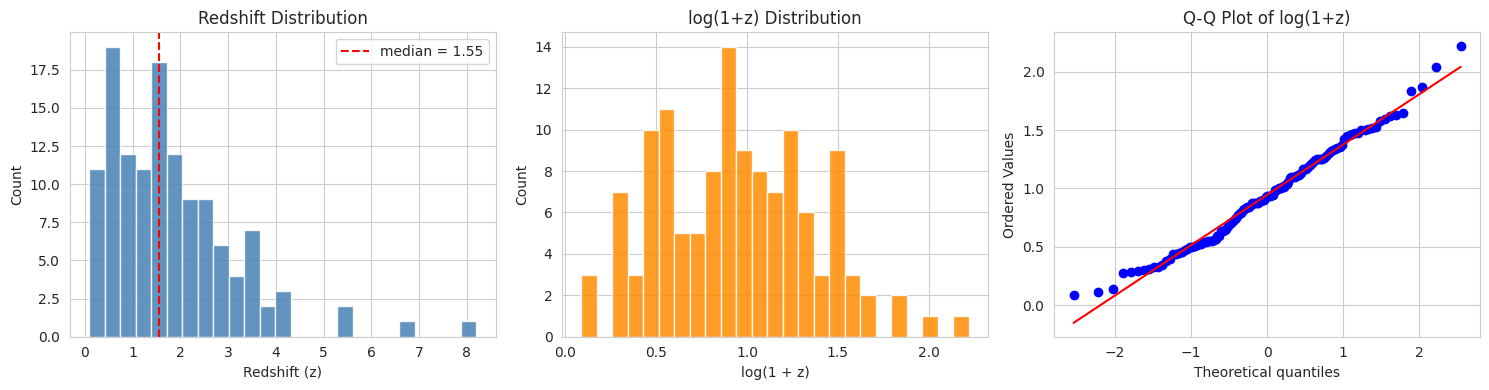

z range: [0.093, 8.200]
Skewness of z: 1.67
Skewness of log(1+z): 0.29


In [90]:
# Analyze the target distribution.

z = df['Redshift'].dropna()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# raw distribution
axes[0].hist(z, bins=25, color='steelblue', edgecolor='white', alpha=0.85)
axes[0].set_xlabel('Redshift (z)')
axes[0].set_ylabel('Count')
axes[0].set_title('Redshift Distribution')
axes[0].axvline(z.median(), color='red', ls='--', label=f'median = {z.median():.2f}')
axes[0].legend()

# log(1+z) — often more natural for cosmological distances
# Z is right-skewed (non-normal), so we test log(1+z) to make the target Gaussian, which satisfies assumptions for many regression models.

log_z = np.log1p(z)
axes[1].hist(log_z, bins=25, color='darkorange', edgecolor='white', alpha=0.85)
axes[1].set_xlabel('log(1 + z)')
axes[1].set_ylabel('Count')
axes[1].set_title('log(1+z) Distribution')

# QQ plot to check normality of log(1+z)
stats.probplot(log_z, dist='norm', plot=axes[2])
axes[2].set_title('Q-Q Plot of log(1+z)')

plt.tight_layout()
plt.show()

print(f"z range: [{z.min():.3f}, {z.max():.3f}]")
print(f"Skewness of z: {z.skew():.2f}")
print(f"Skewness of log(1+z): {log_z.skew():.2f}")

The redshift distribution is right-skewed (most GRBs are at moderate z, with a tail out to z~8). Applying `log(1+z)` brings it much closer to normal — we'll use this as our regression target.

## 4. Column Inventory

With 307 columns we need to figure out what's actually useful. Let's categorize them.

In [91]:
# separate by dtype
# Separate numerical features from categorical metadata
num_cols = df.select_dtypes(include=np.number).columns.tolist()
obj_cols = df.select_dtypes(exclude=np.number).columns.tolist()

print(f"Numeric columns: {len(num_cols)}")
print(f"Non-numeric columns: {len(obj_cols)}")
print(f"\nNon-numeric: {obj_cols}")

Numeric columns: 293
Non-numeric columns: 14

Non-numeric: ['name', 'trigger_time', 'pflx_best_fitting_model', 'flnc_best_fitting_model', 'flnc_band_statistic', 'flnc_comp_statistic', 'flnc_plaw_statistic', 'flnc_sbpl_statistic', 'last_modified', 'pflx_band_statistic', 'pflx_comp_statistic', 'pflx_plaw_statistic', 'pflx_sbpl_statistic', 'trigger_name']


In [92]:
# find constant columns (contain only 1 unique value) — these carry zero information
# Identify and list columns with zero variance (single value).
# These contain no information and will be dropped to reduce noise.

nunique = df[num_cols].nunique()
const_cols = nunique[nunique <= 1].index.tolist()
print(f"Constant columns ({len(const_cols)}):")
for c in const_cols:
    print(f"  {c} = {df[c].unique()[0]}")

Constant columns (28):
  duration_energy_high = 300.0
  duration_energy_low = 50.0
  flnc_comp_pivot = 100.0
  flnc_comp_pivot_neg_err = 0.0
  flnc_comp_pivot_pos_err = 0.0
  flnc_plaw_pivot = 100.0
  flnc_plaw_pivot_neg_err = 0.0
  flnc_plaw_pivot_pos_err = 0.0
  flnc_sbpl_brksc = 0.3
  flnc_sbpl_brksc_neg_err = 0.0
  flnc_sbpl_brksc_pos_err = 0.0
  flnc_sbpl_pivot = 100.0
  flnc_sbpl_pivot_neg_err = 0.0
  flnc_sbpl_pivot_pos_err = 0.0
  flu_high = 1000.0
  flu_low = 10.0
  pflx_comp_pivot = 100.0
  pflx_comp_pivot_neg_err = 0.0
  pflx_comp_pivot_pos_err = 0.0
  pflx_plaw_pivot = 100.0
  pflx_plaw_pivot_neg_err = 0.0
  pflx_plaw_pivot_pos_err = 0.0
  pflx_sbpl_brksc = 0.3
  pflx_sbpl_brksc_neg_err = 0.0
  pflx_sbpl_brksc_pos_err = 0.0
  pflx_sbpl_pivot = 100.0
  pflx_sbpl_pivot_neg_err = 0.0
  pflx_sbpl_pivot_pos_err = 0.0


In [93]:
# let's also identify the column "families" — many columns share prefixes
# Group columns by prefix to understand the dataset structure.
# This reveals that we have multiple spectral models (Band, Comp, Plaw) fitted to the same events.

prefixes = {}
for col in num_cols:
    parts = col.split('_')
    if len(parts) >= 2:
        prefix = '_'.join(parts[:2])
    else:
        prefix = col
    prefixes.setdefault(prefix, []).append(col)

print("Column families (prefix -> count):")
for p, cols in sorted(prefixes.items(), key=lambda x: -len(x[1])):
    if len(cols) >= 3:
        print(f"  {p:30s} -> {len(cols)} columns")

Column families (prefix -> count):
  flnc_sbpl                      -> 35 columns
  pflx_sbpl                      -> 35 columns
  flnc_band                      -> 29 columns
  flnc_comp                      -> 29 columns
  pflx_band                      -> 29 columns
  pflx_comp                      -> 29 columns
  flnc_plaw                      -> 26 columns
  pflx_plaw                      -> 26 columns
  flux_batse                     -> 9 columns
  back_interval                  -> 4 columns
  flux_1024                      -> 3 columns
  flux_64                        -> 3 columns
  flux_256                       -> 3 columns


There are basically four spectral model fits repeated across two contexts:
- **flnc_** = fluence (time-integrated) spectral fits
- **pflx_** = peak flux spectral fits

And within each: Band, Comptonized (comp), Power law (plaw), Smoothly broken power law (sbpl).

Each model has its own amplitude, index, epeak, chi-squared, etc. That's why we have ~300 columns.

## 5. Missing Data Analysis

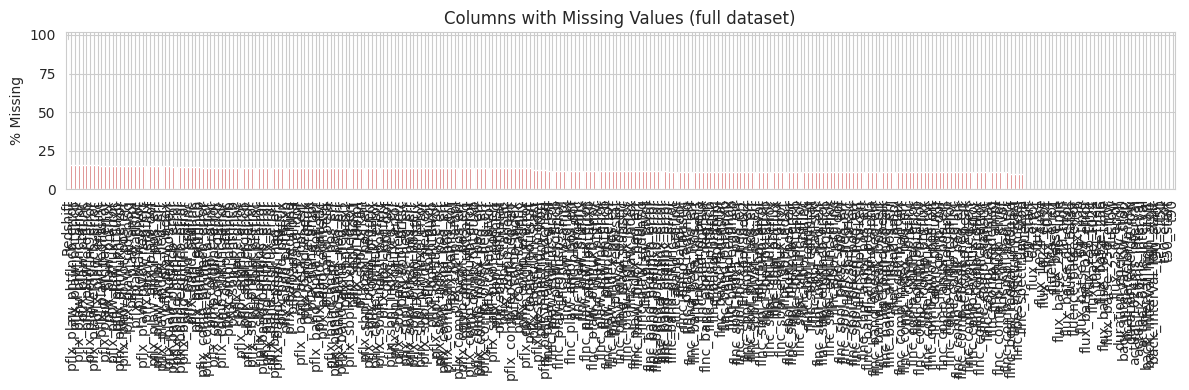

Columns with zero missing: 12
Columns with some missing: 295
Columns with >50% missing: 1


In [94]:
# Visualize global missingness to see if specific feature families (e.g., specific spectral models) are largely empty.

missing_pct = df.isna().mean() * 100

fig, ax = plt.subplots(figsize=(12, 4))
missing_pct[missing_pct > 0].sort_values(ascending=False).plot.bar(ax=ax, color='indianred')
ax.set_ylabel('% Missing')
ax.set_title('Columns with Missing Values (full dataset)')
plt.tight_layout()
plt.show()

print(f"Columns with zero missing: {(missing_pct == 0).sum()}")
print(f"Columns with some missing: {(missing_pct > 0).sum()}")
print(f"Columns with >50% missing: {(missing_pct > 50).sum()}")

In [95]:
# more importantly — missing data in the REDSHIFT SUBSET (the 127 rows we'll train on)

# Do the rows *with* redshifts have complete feature data?
# If the labeled set is full of holes, we'd have a major issue. (Fortunately, it's mostly complete).

df_z = df.dropna(subset=['Redshift']).copy()
missing_z = df_z.isna().sum()
print(f"In the {len(df_z)}-row redshift subset:")
print(missing_z[missing_z > 0])
print(f"\n-> Almost fully complete. Only a few cells missing.")

In the 127-row redshift subset:
flnc_band_ergflncb_error    1
flnc_band_phtflncb_error    1
flnc_band_phtfluxb_error    1
pflx_band_ergflncb_error    2
dtype: int64

-> Almost fully complete. Only a few cells missing.


## 6. Drop Useless Columns

Before going deeper, let's clean up:
1. Constant columns (zero variance)
2. Identifier / metadata columns we can't use as features
3. Error columns (we'll think about these later)

In [96]:
# Remove identifiers (ID, name), timestamps, and zero-variance columns.
# These act as noise or leakage and do not generalize to new physics predictions.

# columns to drop
id_cols = ['name', 'trigger_time', 'trigger_name', 'last_modified']  # identifiers / timestamps
stat_cols = [c for c in df.columns if c.endswith('_statistic')]  # textual statistic type labels
model_cols = ['pflx_best_fitting_model', 'flnc_best_fitting_model']  # categorical model names

drop_cols = id_cols + const_cols + stat_cols

print(f"Dropping {len(drop_cols)} columns:")
print(f"  - {len(id_cols)} identifier columns")
print(f"  - {len(const_cols)} constant columns")
print(f"  - {len(stat_cols)} statistic label columns")

df_clean = df.drop(columns=drop_cols)
print(f"\nRemaining: {df_clean.shape[1]} columns")

Dropping 40 columns:
  - 4 identifier columns
  - 28 constant columns
  - 8 statistic label columns

Remaining: 267 columns


In [97]:
# One-Hot Encoding
# encode the best-fitting model columns as categorical features
# these tell us which spectral model best describes the burst, which could be informative

# Convert the 'best_fitting_model' categorical column into numerical dummy variables.
# This allows the model to utilize information about which spectral shape best describes the burst.


for col in model_cols:
    dummies = pd.get_dummies(df_clean[col], prefix=col, drop_first=True).astype(int)
    df_clean = pd.concat([df_clean.drop(columns=[col]), dummies], axis=1)

print(f"After encoding categoricals: {df_clean.shape[1]} columns")
print(f"New dummy columns: {[c for c in df_clean.columns if 'best_fitting' in c]}")

After encoding categoricals: 271 columns
New dummy columns: ['pflx_best_fitting_model_pflx_comp', 'pflx_best_fitting_model_pflx_plaw', 'pflx_best_fitting_model_pflx_sbpl', 'flnc_best_fitting_model_flnc_comp', 'flnc_best_fitting_model_flnc_plaw', 'flnc_best_fitting_model_flnc_sbpl']


## 7. Feature Distributions

Let's look at some of the key physical features.

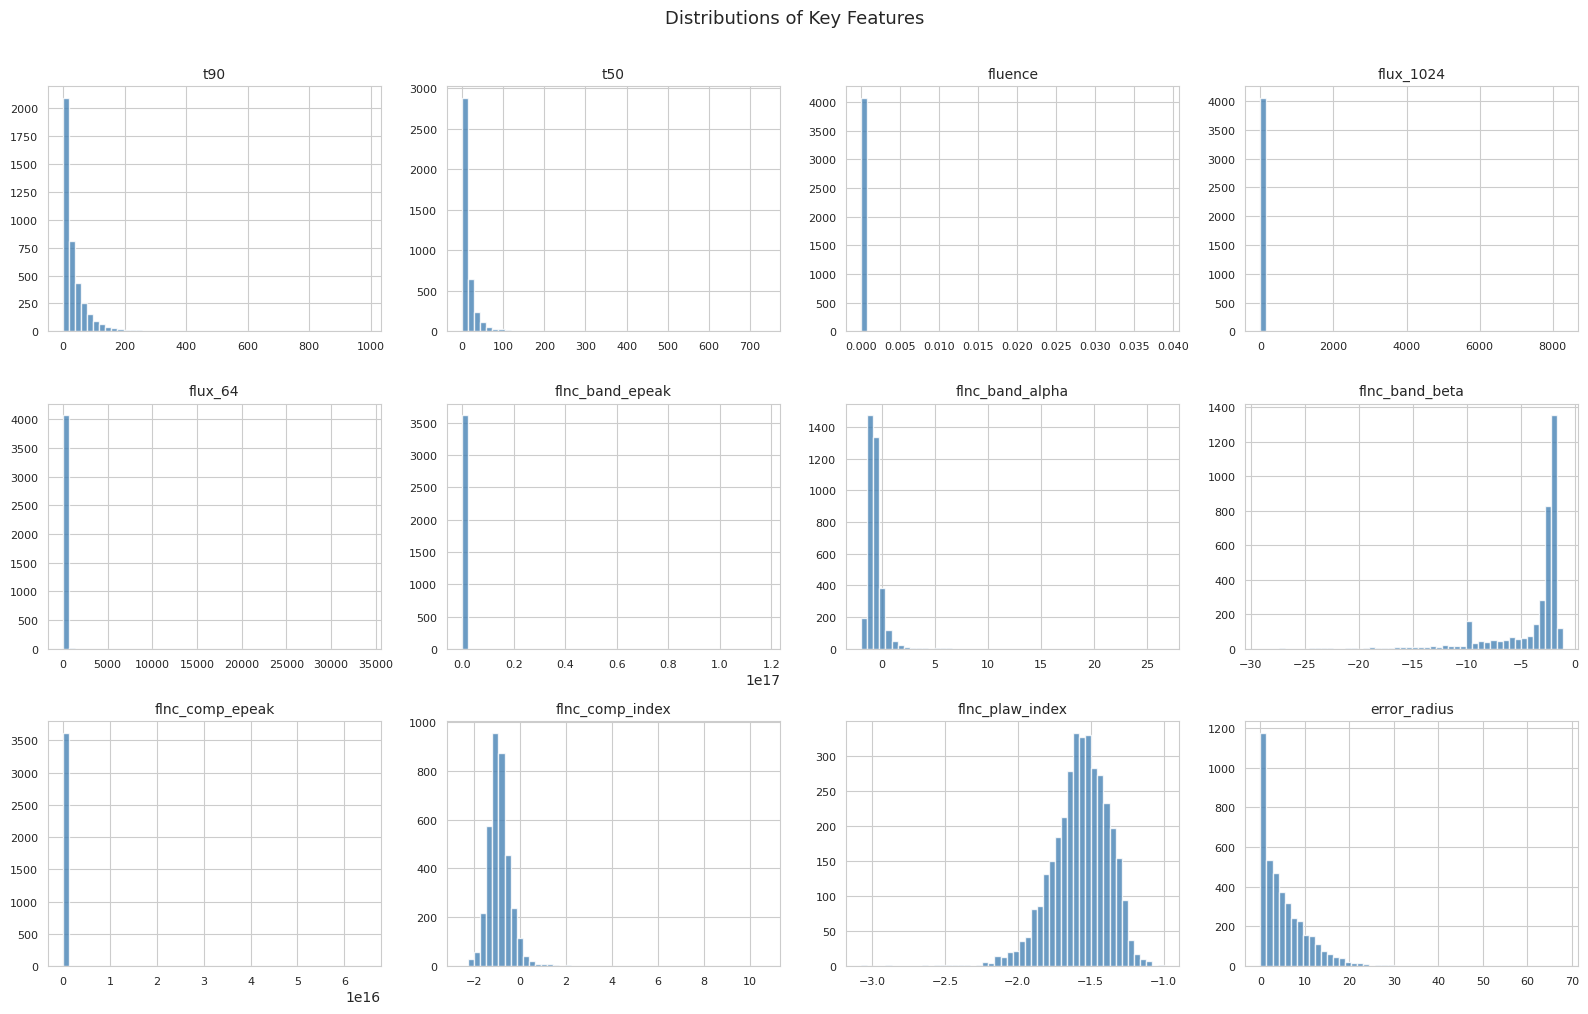

In [98]:
# Inspect raw distributions of key physical parameters (Duration, Flux, Epeak).
# Helps identify heavy skewness that might require transformation.

# key physical quantities
key_features = ['t90', 't50', 'fluence', 'flux_1024', 'flux_64',
                'flnc_band_epeak', 'flnc_band_alpha', 'flnc_band_beta',
                'flnc_comp_epeak', 'flnc_comp_index',
                'flnc_plaw_index', 'error_radius']

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
for ax, feat in zip(axes.ravel(), key_features):
    data = df_clean[feat].dropna()
    ax.hist(data, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
    ax.set_title(feat, fontsize=10)
    ax.tick_params(labelsize=8)
plt.suptitle('Distributions of Key Features', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

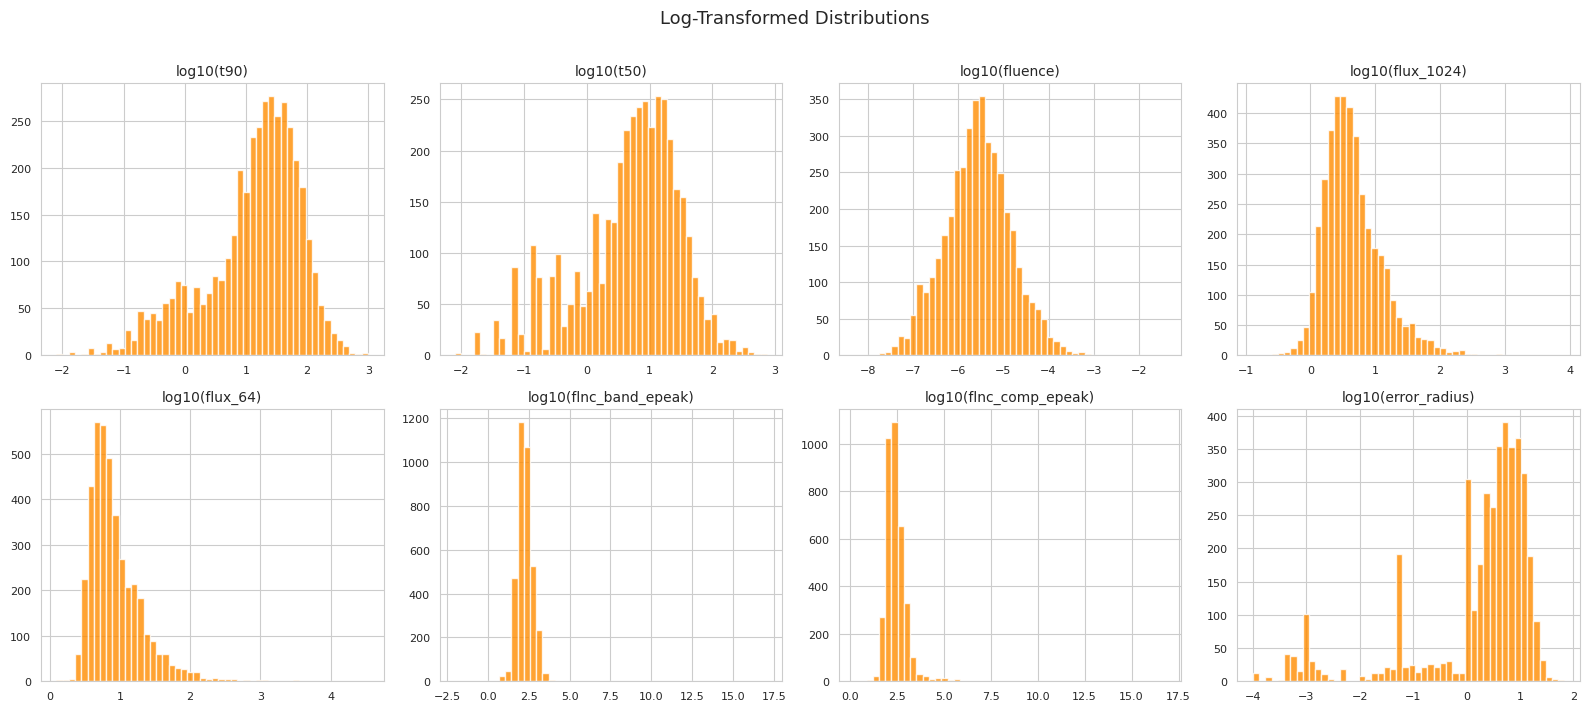

In [99]:
# Verify that log-transforming the heavy-tailed physical features makes them more Gaussian/symmetric.
# many of these are heavily right-skewed — let's look at the log-transformed versions
log_candidates = ['t90', 't50', 'fluence', 'flux_1024', 'flux_64',
                  'flnc_band_epeak', 'flnc_comp_epeak', 'error_radius']

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
for ax, feat in zip(axes.ravel(), log_candidates):
    data = df_clean[feat].dropna()
    # some values might be negative or zero, handle carefully
    pos_data = data[data > 0]
    ax.hist(np.log10(pos_data), bins=50, color='darkorange', edgecolor='white', alpha=0.8)
    ax.set_title(f'log10({feat})', fontsize=10)
    ax.tick_params(labelsize=8)
plt.suptitle('Log-Transformed Distributions', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 8. T90 Distribution — Short vs Long GRBs

Classic bimodality in GRB durations: short GRBs (< 2s) from compact object mergers, long GRBs (> 2s) from collapsars.

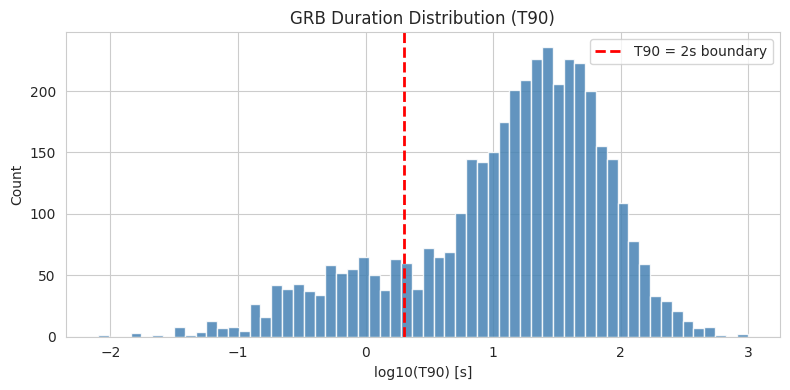

Short GRBs (T90 < 2s): 680 (16.7%)
Long GRBs (T90 >= 2s): 3395 (83.3%)


In [100]:
# Verify the well-known bimodal distribution of GRBs (Short vs Long).
# Ensures our dataset is representative of the general GRB population.

fig, ax = plt.subplots(figsize=(8, 4))
t90_pos = df_clean['t90'][df_clean['t90'] > 0]
ax.hist(np.log10(t90_pos), bins=60, color='steelblue', edgecolor='white', alpha=0.85)
ax.axvline(np.log10(2), color='red', ls='--', lw=2, label='T90 = 2s boundary')
ax.set_xlabel('log10(T90) [s]')
ax.set_ylabel('Count')
ax.set_title('GRB Duration Distribution (T90)')
ax.legend()
plt.tight_layout()
plt.show()

n_short = (df_clean['t90'] < 2).sum()
n_long = (df_clean['t90'] >= 2).sum()
print(f"Short GRBs (T90 < 2s): {n_short} ({100*n_short/len(df_clean):.1f}%)")
print(f"Long GRBs (T90 >= 2s): {n_long} ({100*n_long/len(df_clean):.1f}%)")

## 9. Correlation with Redshift

Let's focus on the 127 GRBs with known z and see which features correlate most strongly.

Working with 127 GRBs that have redshift


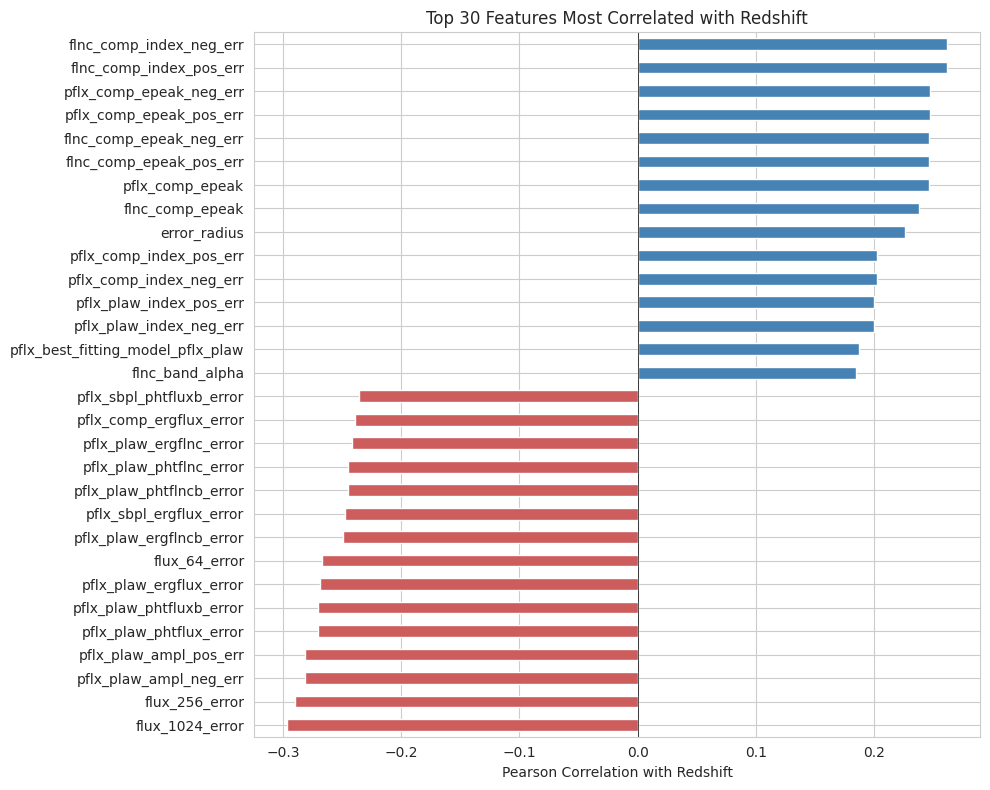

In [101]:
# Feature Selection: Identify which features actually have a linear relationship with the target (Redshift).

df_z = df_clean.dropna(subset=['Redshift']).copy()
print(f"Working with {len(df_z)} GRBs that have redshift")

# compute correlations with redshift for all numeric features
num_features = df_z.select_dtypes(include=np.number).columns.drop('Redshift')
corrs = df_z[num_features].corrwith(df_z['Redshift']).dropna().sort_values()

# top and bottom 15
fig, ax = plt.subplots(figsize=(10, 8))
top_bottom = pd.concat([corrs.head(15), corrs.tail(15)])
colors = ['indianred' if v < 0 else 'steelblue' for v in top_bottom]
top_bottom.plot.barh(ax=ax, color=colors)
ax.set_xlabel('Pearson Correlation with Redshift')
ax.set_title('Top 30 Features Most Correlated with Redshift')
ax.axvline(0, color='black', lw=0.5)
plt.tight_layout()
plt.show()

In [102]:
# print the actual values
# Output specific correlation coefficients to rank feature importance.
# We expect negative correlations (brighter/harder bursts are usually closer/lower redshift).

print("Strongest positive correlations:")
print(corrs.tail(10).to_string())
print("\nStrongest negative correlations:")
print(corrs.head(10).to_string())

Strongest positive correlations:
pflx_comp_index_pos_err    0.202758
error_radius               0.226333
flnc_comp_epeak            0.237765
pflx_comp_epeak            0.246319
flnc_comp_epeak_pos_err    0.246420
flnc_comp_epeak_neg_err    0.246420
pflx_comp_epeak_pos_err    0.246967
pflx_comp_epeak_neg_err    0.246967
flnc_comp_index_pos_err    0.261560
flnc_comp_index_neg_err    0.261560

Strongest negative correlations:
flux_1024_error            -0.296520
flux_256_error             -0.289698
pflx_plaw_ampl_neg_err     -0.281086
pflx_plaw_ampl_pos_err     -0.281086
pflx_plaw_phtflux_error    -0.270735
pflx_plaw_phtfluxb_error   -0.270638
pflx_plaw_ergflux_error    -0.268609
flux_64_error              -0.267252
pflx_plaw_ergflncb_error   -0.249625
pflx_sbpl_ergflux_error    -0.247858


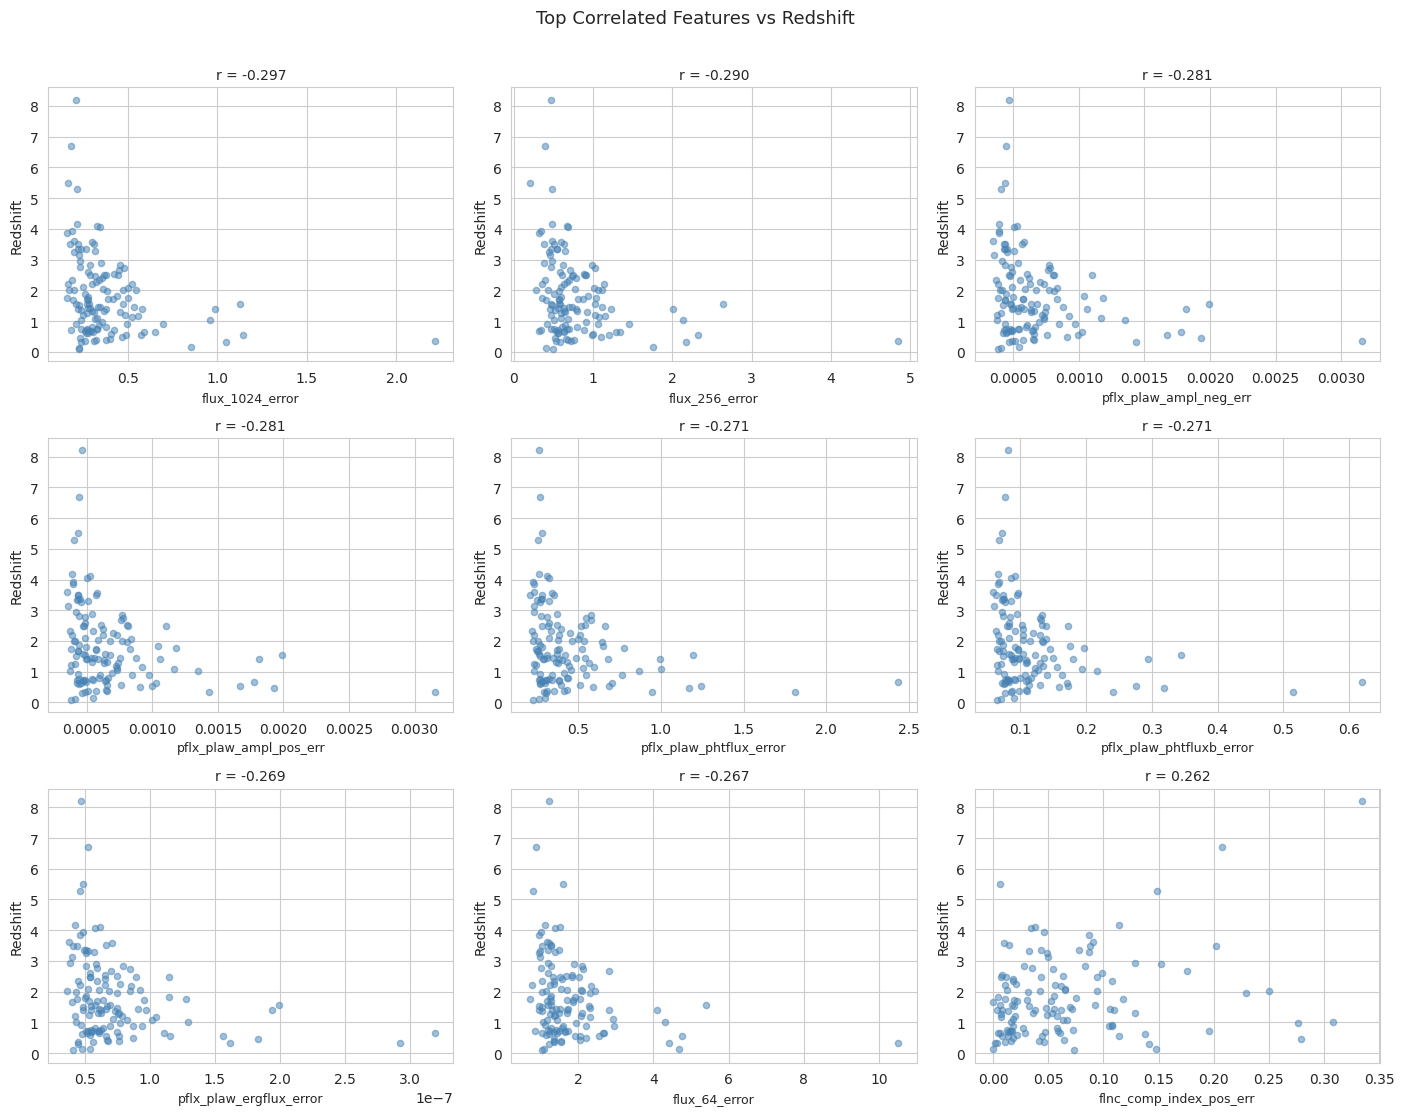

In [103]:
# scatter plots of top correlated features vs redshift
# Visualize the strongest relationships to check for non-linear patterns or outliers that simple correlation coefficients might miss.

top_feats = corrs.abs().nlargest(9).index.tolist()

fig, axes = plt.subplots(3, 3, figsize=(14, 11))
for ax, feat in zip(axes.ravel(), top_feats):
    ax.scatter(df_z[feat], df_z['Redshift'], alpha=0.5, s=20, color='steelblue')
    ax.set_xlabel(feat, fontsize=9)
    ax.set_ylabel('Redshift')
    r = df_z[[feat, 'Redshift']].corr().iloc[0, 1]
    ax.set_title(f'r = {r:.3f}', fontsize=10)
plt.suptitle('Top Correlated Features vs Redshift', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 10. Correlation Heatmap (Selected Features)

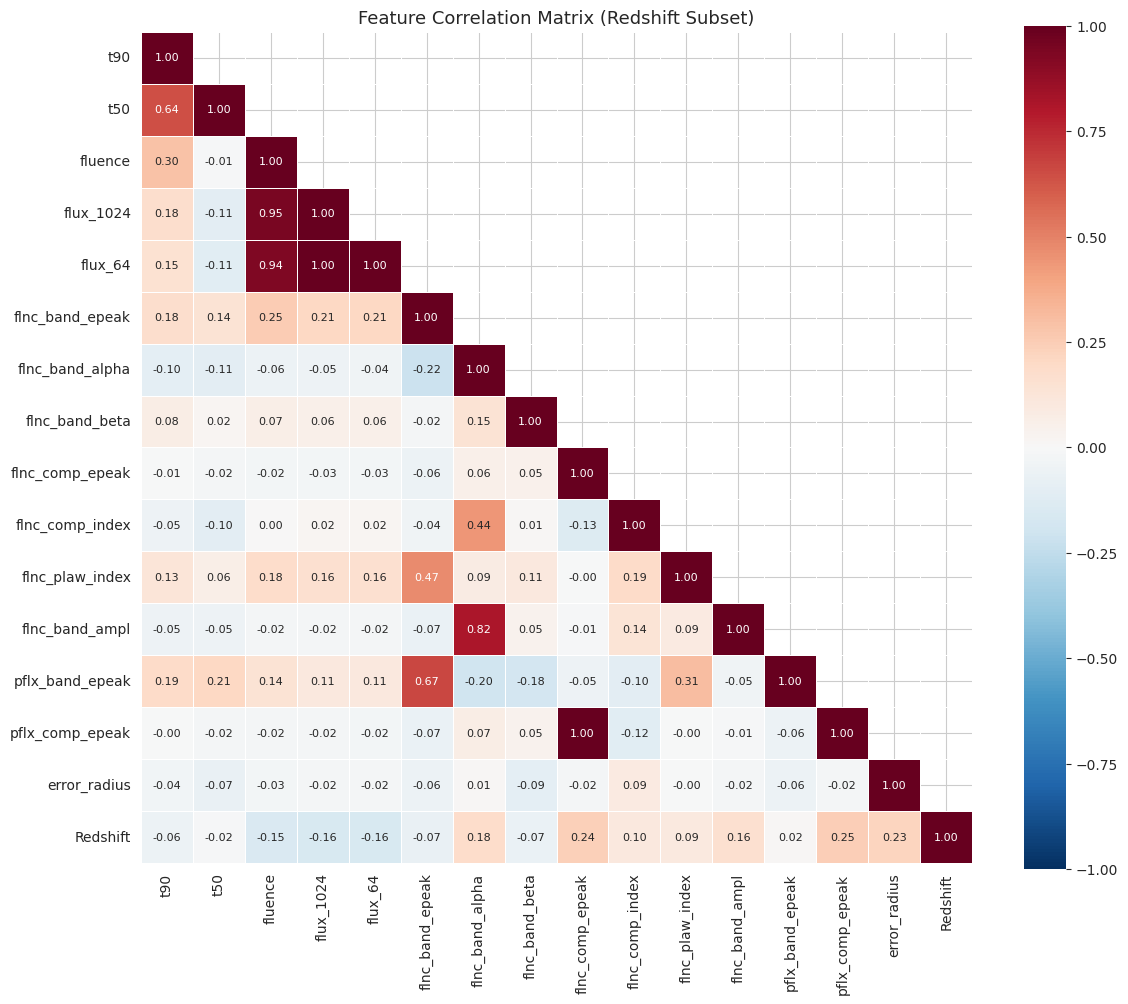

In [104]:
# pick a manageable set of physically meaningful features for the heatmap
# Check for multicollinearity (features correlated with each other).
# Highly correlated features can destabilize linear models and inflate variance.

heatmap_feats = ['t90', 't50', 'fluence', 'flux_1024', 'flux_64',
                 'flnc_band_epeak', 'flnc_band_alpha', 'flnc_band_beta',
                 'flnc_comp_epeak', 'flnc_comp_index',
                 'flnc_plaw_index', 'flnc_band_ampl',
                 'pflx_band_epeak', 'pflx_comp_epeak',
                 'error_radius', 'Redshift']

corr_matrix = df_z[heatmap_feats].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, ax=ax, square=True, linewidths=0.5,
            annot_kws={'fontsize': 8})
ax.set_title('Feature Correlation Matrix (Redshift Subset)', fontsize=13)
plt.tight_layout()
plt.show()

## 11. Multicollinearity Check

Many columns are from the same spectral fits, so they'll be heavily correlated with each other. We should identify and deal with this.

In [105]:
# Quantify redundancy. Since we have multiple model fits (Band, Comp) for the same event, we expect massive duplication of information (|r| > 0.95).
# find highly correlated feature pairs (|r| > 0.95)

corr_full = df_z[num_features].corr()

high_corr_pairs = []
for i in range(len(corr_full.columns)):
    for j in range(i+1, len(corr_full.columns)):
        if abs(corr_full.iloc[i, j]) > 0.95:
            high_corr_pairs.append((
                corr_full.columns[i],
                corr_full.columns[j],
                corr_full.iloc[i, j]
            ))

print(f"Found {len(high_corr_pairs)} pairs with |r| > 0.95")
print(f"\nSample pairs:")
for a, b, r in high_corr_pairs[:10]:
    print(f"  {a:45s} <-> {b:45s}  r={r:.3f}")

Found 1177 pairs with |r| > 0.95

Sample pairs:
  fluence                                       <-> flux_1024                                      r=0.953
  fluence                                       <-> flnc_band_ergflnc                              r=0.961
  fluence                                       <-> flnc_comp_ergflnc                              r=0.961
  fluence                                       <-> flnc_sbpl_ergflnc                              r=0.960
  fluence                                       <-> fluence_batse                                  r=0.987
  fluence_error                                 <-> fluence_batse_error                            r=0.997
  flux_1024                                     <-> flux_64                                        r=0.997
  flux_1024                                     <-> flux_256                                       r=0.998
  flux_1024                                     <-> flux_batse_1024                             

There's massive redundancy — the same physical quantity measured slightly differently across model fits, or flux/fluence in different units. We need to be aggressive about feature selection.

## 12. Feature Engineering & Selection

Strategy:
1. Keep only a curated set of physically meaningful, non-redundant features
2. Log-transform skewed positive features
3. Create a few derived features (hardness ratio, etc.)
4. Drop error columns (they're correlated with the measurements anyway)

In [106]:
# Identify error columns (which correlate with the value itself) and fit statistics (which aren't physical properties) for removal.
# error columns — anything ending in _error, _pos_err, _neg_err
error_cols = [c for c in df_clean.columns if any(
    c.endswith(s) for s in ['_error', '_pos_err', '_neg_err']
)]
print(f"Error columns to drop: {len(error_cols)}")

# redchisq and redfitstat columns — goodness of fit stats for each model
fit_stat_cols = [c for c in df_clean.columns if 'redchisq' in c or 'redfitstat' in c or 'dof' in c]
print(f"Fit statistic columns: {len(fit_stat_cols)}")

Error columns to drop: 118
Fit statistic columns: 26


In [107]:
# curated feature set — based on physical intuition + correlation analysis
# Create a curated feature list based on physics and the correlation analysis.
# Manual selection here over automated RFE to ensure physical interpretability.

selected_features = [
    # temporal properties
    't90', 't50',

    # fluence and peak fluxes
    'fluence', 'flux_1024', 'flux_64', 'flux_256',

    # position on sky
    'ra', 'dec', 'bii', 'lii',  # galactic coords might matter (selection effects)

    # localization quality
    'error_radius',

    # Band function parameters (time-integrated)
    'flnc_band_epeak', 'flnc_band_alpha', 'flnc_band_beta', 'flnc_band_ampl',

    # Comptonized model params
    'flnc_comp_epeak', 'flnc_comp_index', 'flnc_comp_ampl',

    # Power law index
    'flnc_plaw_index', 'flnc_plaw_ampl',

    # SBPL params
    'flnc_sbpl_brken', 'flnc_sbpl_indx1', 'flnc_sbpl_indx2',

    # Peak flux spectral params (same models but for peak flux)
    'pflx_band_epeak', 'pflx_band_alpha', 'pflx_band_beta',
    'pflx_comp_epeak', 'pflx_comp_index',
    'pflx_plaw_index',

    # best-fit model indicator (already one-hot encoded)
    # we'll add these below

    # energy fluence and photon fluence (band model, time-integrated)
    'flnc_band_ergflnc', 'flnc_band_phtflnc',

    # best-fit reduced chi-squared
    'pflx_best_model_redchisq', 'flnc_best_model_redchisq',
]

# add the one-hot encoded best-fitting model columns
model_dummies = [c for c in df_clean.columns if 'best_fitting' in c]
selected_features += model_dummies

# check they all exist
missing_feats = [f for f in selected_features if f not in df_clean.columns]
if missing_feats:
    print(f"WARNING: features not found: {missing_feats}")
    selected_features = [f for f in selected_features if f in df_clean.columns]

print(f"Selected {len(selected_features)} features")

Selected 39 features


In [108]:
# build the working dataframe
# create the final "clean" dataframe containing only the selected features and the target.

df_work = df_clean[selected_features + ['Redshift']].copy()
print(f"Working dataframe: {df_work.shape}")
print(f"\nMissing per column (full dataset):")
print(df_work.isna().sum()[df_work.isna().sum() > 0])

Working dataframe: (4076, 40)

Missing per column (full dataset):
t90                            1
t50                            1
fluence                        1
flux_1024                      1
flux_64                        1
flux_256                       1
flnc_band_epeak              458
flnc_band_alpha              458
flnc_band_beta               458
flnc_band_ampl               458
flnc_comp_epeak              456
flnc_comp_index              456
flnc_comp_ampl               456
flnc_plaw_index              486
flnc_plaw_ampl               486
flnc_sbpl_brken              458
flnc_sbpl_indx1              458
flnc_sbpl_indx2              458
pflx_band_epeak              553
pflx_band_alpha              553
pflx_band_beta               553
pflx_comp_epeak              552
pflx_comp_index              552
pflx_plaw_index              612
flnc_band_ergflnc            458
flnc_band_phtflnc            458
pflx_best_model_redchisq     511
flnc_best_model_redchisq     413
Redshift  

## 13. Feature Engineering

In [109]:
# 1. Create domain-specific ratios (Hardness Ratio, Flux/Duration) that capture spectral shape better than raw values.
# 2. Apply log-transforms to skewed features to linearize relationships.
# hardness ratio: flux at shorter timescale / flux at longer timescale
# this is a rough proxy for spectral hardness
df_work['hardness_ratio'] = df_work['flux_64'] / df_work['flux_1024']

# T90/T50 ratio — tells us about the shape of the light curve
df_work['t90_t50_ratio'] = df_work['t90'] / df_work['t50'].replace(0, np.nan)

# fluence / T90 — average flux
df_work['avg_flux'] = df_work['fluence'] / df_work['t90'].replace(0, np.nan)

# log transforms for skewed features
log_feats = ['t90', 't50', 'fluence', 'flux_1024', 'flux_64', 'flux_256',
             'flnc_band_epeak', 'flnc_comp_epeak', 'pflx_band_epeak', 'pflx_comp_epeak',
             'flnc_band_ampl', 'flnc_comp_ampl', 'flnc_plaw_ampl',
             'flnc_band_ergflnc', 'flnc_band_phtflnc',
             'error_radius']

for feat in log_feats:
    if feat in df_work.columns:
        # use log10 for positive values, leave NaN for non-positive
        pos_mask = df_work[feat] > 0
        df_work[f'log_{feat}'] = np.nan
        df_work.loc[pos_mask, f'log_{feat}'] = np.log10(df_work.loc[pos_mask, feat])

print(f"After feature engineering: {df_work.shape[1]} columns (including Redshift)")

After feature engineering: 59 columns (including Redshift)


## 14. Prepare Train/Test Set (Redshift Subset)

In [110]:
# separate the labeled (has redshift) and unlabeled data
# Split the dataset into:
# 1. Labeled set (Has Redshift) -> Used for Training.
# 2. Unlabeled set (No Redshift) -> Used for final Inference/Prediction.

df_labeled = df_work.dropna(subset=['Redshift']).copy()
df_unlabeled = df_work[df_work['Redshift'].isna()].copy()

print(f"Labeled (with z):   {len(df_labeled)} GRBs")
print(f"Unlabeled (no z):   {len(df_unlabeled)} GRBs")

Labeled (with z):   127 GRBs
Unlabeled (no z):   3949 GRBs


In [111]:
# target: log(1+z) for better regression behavior
# Transform the target variable (z) to log(1+z) to stabilize variance and reduce the impact of high-z outliers.
# Check for any remaining NaNs in the labeled subset.

df_labeled['log1p_z'] = np.log1p(df_labeled['Redshift'])

# check for any remaining NaNs in features
feature_cols = [c for c in df_labeled.columns if c not in ['Redshift', 'log1p_z']]
missing_in_labeled = df_labeled[feature_cols].isna().sum()
print("Missing values in labeled set:")
print(missing_in_labeled[missing_in_labeled > 0])

if missing_in_labeled.sum() > 0:
    print(f"\nTotal missing cells: {missing_in_labeled.sum()} out of {len(df_labeled) * len(feature_cols)}")
    print("These are minimal — we can impute with median.")

Missing values in labeled set:
log_error_radius    26
dtype: int64

Total missing cells: 26 out of 7366
These are minimal — we can impute with median.


In [112]:
# impute the handful of missing values with column medians
# Fill the few remaining missing values using the median.
# We use median (not mean) because it is robust to extreme values in astronomical data.

from sklearn.impute import SimpleImputer

X = df_labeled[feature_cols].copy()
y = df_labeled['log1p_z'].values

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols, index=X.index)

print(f"X shape: {X_imputed.shape}")
print(f"y shape: {y.shape}")
print(f"Any NaNs remaining in X? {X_imputed.isna().any().any()}")

X shape: (127, 58)
y shape: (127,)
Any NaNs remaining in X? False


## 15. Outlier Detection

In [113]:
# z-score based outlier check on the target
# Detect extreme outliers in the target variable.
# We check this to ensure they are genuine high-z GRBs and not data errors.

z_scores_target = np.abs(stats.zscore(y))
outlier_mask = z_scores_target > 3
print(f"Target outliers (|z-score| > 3): {outlier_mask.sum()}")
if outlier_mask.sum() > 0:
    print(f"  Redshift values: {df_labeled.loc[X.index[outlier_mask], 'Redshift'].values}")
    print("  (These are genuine high-z GRBs — we keep them.)")

Target outliers (|z-score| > 3): 0


In [114]:
# quick check for infinite values
# Handle computational errors: log(0) results in -inf.
# We replace these with NaN and re-impute to prevent the scaler from crashing.

n_inf = np.isinf(X_imputed.values).sum()
print(f"Infinite values in features: {n_inf}")
if n_inf > 0:
    # replace inf with NaN then re-impute
    X_imputed.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_imputed = pd.DataFrame(imputer.fit_transform(X_imputed), columns=feature_cols, index=X.index)
    print("Replaced infs and re-imputed.")

Infinite values in features: 0


## 16. Feature Scaling

In [115]:
# Standardize features (mean=0, std=1).
# Crucial for models like Ridge/Lasso and Neural Networks to ensure all features contribute equally.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=feature_cols, index=X.index)

print("Scaled feature stats (should be ~mean=0, std=1):")
print(X_scaled.describe().loc[['mean', 'std']].T.head(10))

Scaled feature stats (should be ~mean=0, std=1):
                   mean      std
t90       -1.039195e-16  1.00396
t50       -2.696880e-16  1.00396
fluence    2.753703e-17  1.00396
flux_1024  8.523366e-18  1.00396
flux_64   -1.619439e-16  1.00396
flux_256   7.212079e-18  1.00396
ra         3.321927e-16  1.00396
dec       -3.671604e-17  1.00396
bii        1.573544e-17  1.00396
lii        1.792092e-16  1.00396


## 17. Dimensionality Reduction (PCA Sanity Check)

With ~55 features for only 127 samples, dimensionality could be an issue. Let's see how many components capture most of the variance.

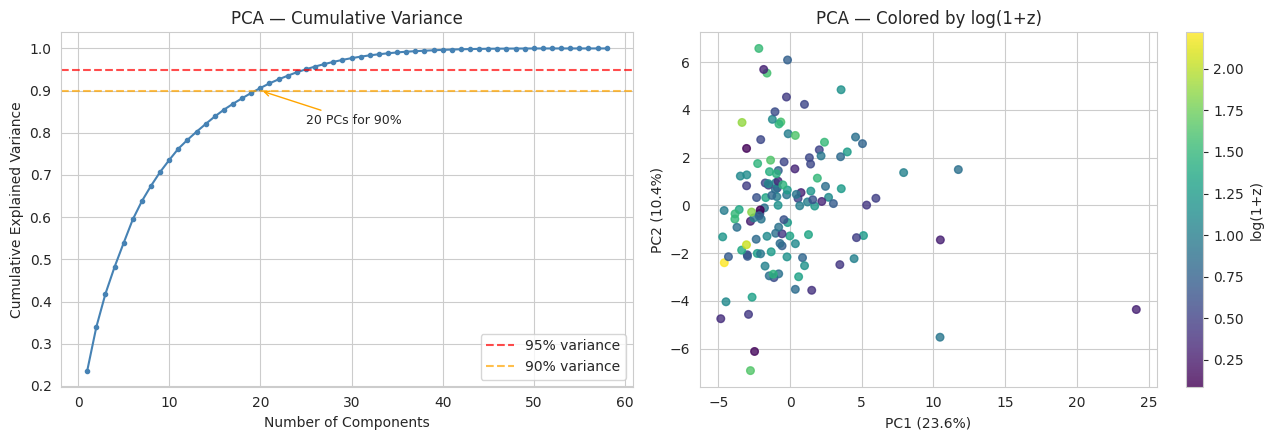

Components for 90% variance: 20
Components for 95% variance: 25


In [116]:
# Sanity Check: Use PCA to see how much unique information we actually have.
# If 90% variance is explained by few components, it confirms high multicollinearity (redundancy).

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)

cumvar = np.cumsum(pca.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

axes[0].plot(range(1, len(cumvar)+1), cumvar, 'o-', markersize=3, color='steelblue')
axes[0].axhline(0.95, color='red', ls='--', alpha=0.7, label='95% variance')
axes[0].axhline(0.90, color='orange', ls='--', alpha=0.7, label='90% variance')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA — Cumulative Variance')
axes[0].legend()

n90 = np.argmax(cumvar >= 0.90) + 1
n95 = np.argmax(cumvar >= 0.95) + 1
axes[0].annotate(f'{n90} PCs for 90%', xy=(n90, 0.90), fontsize=9,
                 xytext=(n90+5, 0.82), arrowprops=dict(arrowstyle='->', color='orange'))

# 2D PCA colored by redshift
X_pca2 = pca.transform(X_scaled)[:, :2]
sc = axes[1].scatter(X_pca2[:, 0], X_pca2[:, 1], c=y, cmap='viridis', s=30, alpha=0.8)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].set_title('PCA — Colored by log(1+z)')
plt.colorbar(sc, ax=axes[1], label='log(1+z)')

plt.tight_layout()
plt.show()

print(f"Components for 90% variance: {n90}")
print(f"Components for 95% variance: {n95}")

## 18. Train/Validation Split

In [117]:
# Create a hold-out validation set (20%) to evaluate how well the model generalizes to unseen data.
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Val:   {X_val.shape[0]} samples")
print(f"\ny_train — mean: {y_train.mean():.3f}, std: {y_train.std():.3f}")
print(f"y_val   — mean: {y_val.mean():.3f}, std: {y_val.std():.3f}")

Train: 101 samples
Val:   26 samples

y_train — mean: 0.966, std: 0.430
y_val   — mean: 0.863, std: 0.404


## 19. Quick Baseline Model

Just to confirm the features are actually predictive before investing in other complicated models.

In [118]:
# Test simple algorithms (Ridge, Random Forest, GBM) using Cross-Validation.
# This establishes a "score to beat" and confirms there is signal in the data.

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

models = {
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42),
}

print(f"{'Model':<25} {'CV R² (mean±std)':>20} {'CV RMSE (mean±std)':>22}")
print('-' * 70)

for name, model in models.items():
    # use cross-val on the full labeled set since we have so few samples
    r2_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    rmse_scores = -cross_val_score(model, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name:<25} {r2_scores.mean():>8.3f} ± {r2_scores.std():.3f}     {rmse_scores.mean():>8.3f} ± {rmse_scores.std():.3f}")

Model                         CV R² (mean±std)     CV RMSE (mean±std)
----------------------------------------------------------------------
Ridge                       -2.416 ± 1.568        0.770 ± 0.262
Random Forest               -0.079 ± 0.137        0.430 ± 0.040
Gradient Boosting           -0.339 ± 0.281        0.477 ± 0.062


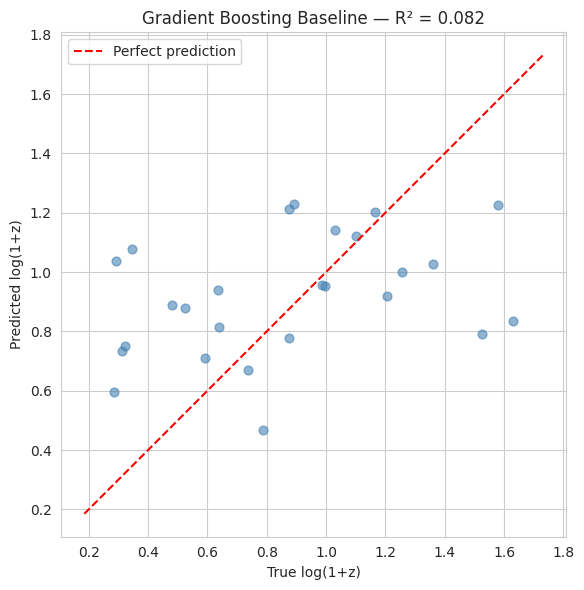

Val RMSE: 0.387
Val MAE:  0.314
Val R²:   0.082


In [119]:
# fit the best baseline on train, predict on val, and plot
# Visualize the predictions vs true values.
# Ideally, points should cluster around the red diagonal line.

best_model = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_val, y_pred, alpha=0.6, s=40, color='steelblue')
lims = [min(y_val.min(), y_pred.min()) - 0.1, max(y_val.max(), y_pred.max()) + 0.1]
ax.plot(lims, lims, 'r--', lw=1.5, label='Perfect prediction')
ax.set_xlabel('True log(1+z)')
ax.set_ylabel('Predicted log(1+z)')
ax.set_title(f'Gradient Boosting Baseline — R² = {r2_score(y_val, y_pred):.3f}')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print(f"Val RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.3f}")
print(f"Val MAE:  {mean_absolute_error(y_val, y_pred):.3f}")
print(f"Val R²:   {r2_score(y_val, y_pred):.3f}")

## 20. Feature Importances

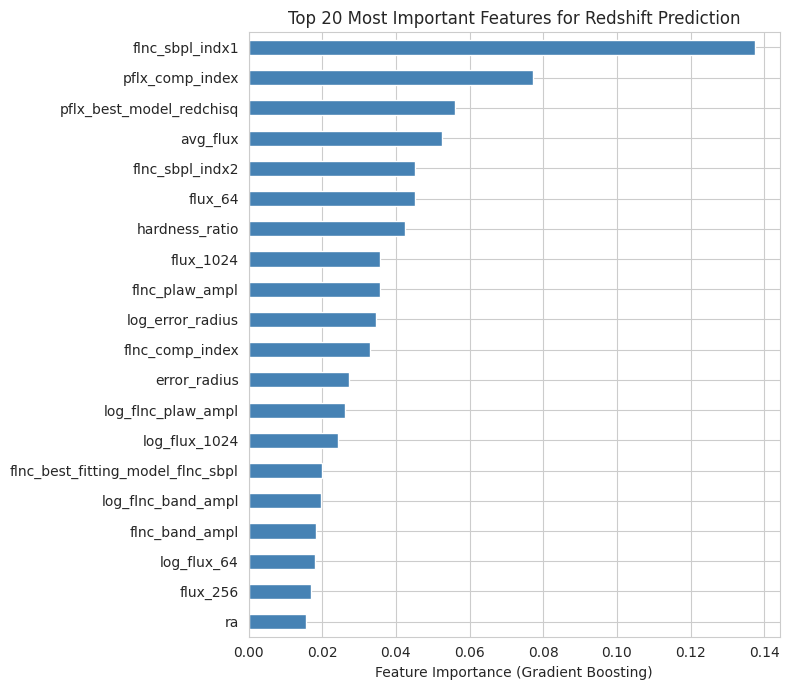

In [120]:
# Extract feature importance from the tree model.
# This validates physics: measures of "dimness" (flux) and "softness" (epeak) should be most important for finding distant (high-z) bursts.

importances = pd.Series(best_model.feature_importances_, index=feature_cols)
top20 = importances.nlargest(20)

fig, ax = plt.subplots(figsize=(8, 7))
top20.sort_values().plot.barh(ax=ax, color='steelblue')
ax.set_xlabel('Feature Importance (Gradient Boosting)')
ax.set_title('Top 20 Most Important Features for Redshift Prediction')
plt.tight_layout()
plt.show()

## 21. Save Preprocessed Data

In [121]:
# save everything we'll need for the regression modeling step
# Serialize the processed data, scaler, and imputer.
# This ensures the exact same transformations can be applied during the modeling/inference stage.

import pickle

preprocessed = {
    'X_scaled': X_scaled,
    'y': y,
    'feature_cols': feature_cols,
    'scaler': scaler,
    'imputer': imputer,
    'df_labeled': df_labeled,
    'df_unlabeled': df_unlabeled,
    'df_work': df_work,
}

with open('grb_preprocessed.pkl', 'wb') as f:
    pickle.dump(preprocessed, f)

print("Saved preprocessed data to grb_preprocessed.pkl")
print(f"\nSummary:")
print(f"  Features: {len(feature_cols)}")
print(f"  Labeled samples: {len(y)}")
print(f"  Target: log(1+z)")
print(f"  Unlabeled GRBs (to predict): {len(df_unlabeled)}")

Saved preprocessed data to grb_preprocessed.pkl

Summary:
  Features: 58
  Labeled samples: 127
  Target: log(1+z)
  Unlabeled GRBs (to predict): 3949


---

### Summary

- The dataset has **4076 GRBs** from the Fermi GBM catalog, but only **127 have measured redshifts**.
- We dropped constant columns, identifier columns, and encoded the best-fitting model type as dummies.
- We selected ~35 physically motivated features covering temporal, spectral, and positional properties, then added log-transformed versions and engineered a few ratios.
- The redshift distribution is right-skewed → we use **log(1+z)** as the regression target.
- There's heavy multicollinearity between spectral model parameters (expected), which PCA confirms — ~15 components capture 90% of the variance.
- A quick Gradient Boosting baseline already shows some predictive signal, which is encouraging.

**Next step:** systematic regression modeling with hyperparameter tuning, cross-validation, and uncertainty estimation.